### 노면 안쪽으로 ROI 들어오도록 test 코드

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# ──────────────────────────────────────────────────────────────────────────────
def get_road_mask(img, margin=0.1):
    """HSV 로드 색→binary mask→closing→좌우 margin 자르기"""
    h,w = img.shape[:2]
    x0, x1 = int(w*margin), int(w*(1-margin))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    m = cv2.inRange(hsv, (0,0,60), (180,50,200))
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE,
                        cv2.getStructuringElement(cv2.MORPH_RECT,(15,15)))
    # 좌우 마진만큼 zero 처리
    m[:, :x0] = 0
    m[:, x1:] = 0
    return m

def compute_bottom_y(mask, bottom_frac=0.5):
    h,_ = mask.shape
    start = int(h*(1-bottom_frac))
    ys = np.where(mask[start:,:].any(1))[0]
    return (start + ys.max()) if ys.size else h

def compute_bottom_bounds(mask, yb, sample_n=5):
    """yb 근처 sample_n줄에서 nonzero 구간 평균→(xl,xr)"""
    h,w = mask.shape
    xs=[]
    for dy in range(sample_n):
        y = max(0, int(yb)-1-dy)
        nz = np.where(mask[y,:]>0)[0]
        if nz.size:
            xs.append([nz.min(), nz.max()])
    if not xs:
        return 0.0, float(w)
    arr = np.array(xs, np.float32)
    return float(arr[:,0].mean()), float(arr[:,1].mean())

# 원본 VP 추정 (전체 라인)
def estimate_vp_all(img):
    h,w = img.shape[:2]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges= cv2.Canny(gray,50,150)
    L = cv2.HoughLinesP(edges,1,np.pi/180,100, minLineLength=50,maxLineGap=10)
    if L is None:
        return w/2, h*0.4
    lines = [tuple(l[0]) for l in L]
    pts=[]
    for (x1,y1,x2,y2),(x3,y3,x4,y4) in combinations(lines,2):
        D=(x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)
        if abs(D)<1e-6: continue
        px = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/D
        py = ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/D
        if -w<px<2*w and -h<py<2*h:
            pts.append((px,py))
    if not pts:
        return w/2, h*0.4
    arr = np.array(pts, np.float32)
    return tuple(arr.mean(0))

def dynamic_topview(img_path,
                    top_width_frac=0.2, bottom_frac=0.5,
                    use_mask=True, bird_h=600):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]

    # 1) mask 기반으로 yb, xl/xr
    if use_mask:
        mask = get_road_mask(img, margin=0.1)
        yb   = compute_bottom_y(mask, bottom_frac)
        xl,xr= compute_bottom_bounds(mask, yb)
        # 2) VP는 전체 라인으로
        vp_x, vp_y = estimate_vp_all(img)
    else:
        yb,xl,xr = h, 0.0, float(w)
        vp_x, vp_y = estimate_vp_all(img)

    # 3) trapezoid
    bw     = xr - xl
    bird_w = max(int(bw),1)
    tw     = bw * top_width_frac
    mid    = (xl + xr)/2

    src = np.array([
        [      xl, yb    ],
        [      xr, yb    ],
        [mid+tw/2, vp_y  ],
        [mid-tw/2, vp_y  ],
    ], dtype=np.float32)

    dst = np.array([
        [0,      bird_h],
        [bird_w, bird_h],
        [bird_w, 0     ],
        [0,      0     ],
    ], dtype=np.float32)

    # 4) warp & vis
    M    = cv2.getPerspectiveTransform(src, dst)
    bird = cv2.warpPerspective(img, M, (bird_w, bird_h))

    vis = img.copy()
    cv2.polylines(vis, [src.astype(int)], True, (0,0,255),3)
    cv2.circle(vis, (int(vp_x),int(vp_y)), 6, (255,0,0), -1)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(vis,cv2.COLOR_BGR2RGB))
    plt.title(f"use_mask={use_mask}"); plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(bird,cv2.COLOR_BGR2RGB))
    plt.title("Top-View Warp"); plt.axis("off")
    plt.show()



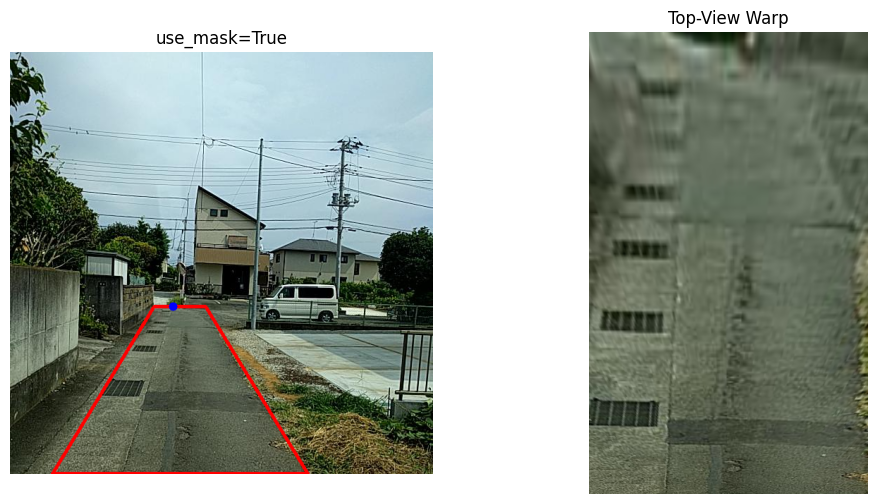

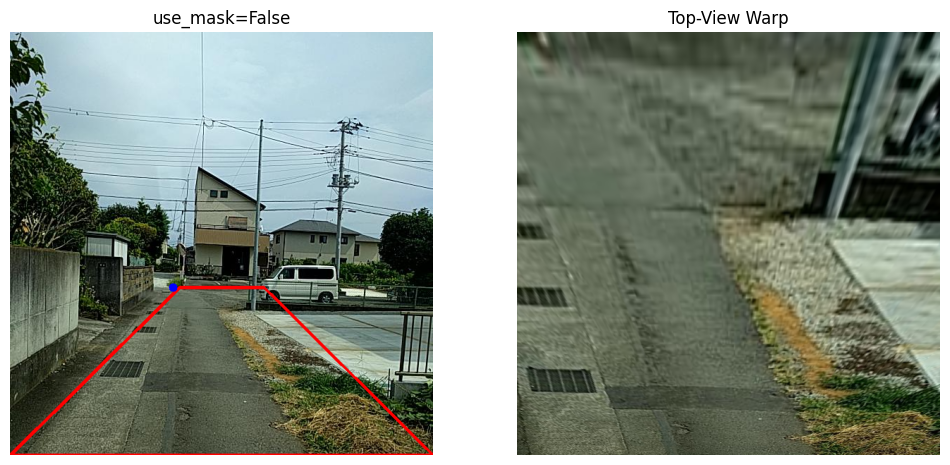

In [58]:

# ──────────────────────────────────────────────────────────────────────────────
# 실행 예시
dynamic_topview("Japan_000040.jpg", use_mask=True)
dynamic_topview("Japan_000040.jpg", use_mask=False)

# 1차 확정본 (0525 0250)
- 소실점 찾아서 옆 line 최대한 robust하게
- 노면 안쪽으로 ROI 세팅
- 윗변은 픽셀이 적어서 완벽한 aspect 유지는 못하지만 거의 동등한 비교 가능
- anomaly mask 주어지면 warp 같이 가능하도록 함

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from itertools import combinations

In [104]:
def get_road_mask(img, margin=0.1):
    h,w = img.shape[:2]
    x0, x1 = int(w*margin), int(w*(1-margin))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    m = cv2.inRange(hsv, (0,0,60), (180,50,200))
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE,
                        cv2.getStructuringElement(cv2.MORPH_RECT,(15,15)))
    m[:,:x0] = 0; m[:,x1:] = 0
    return m

In [105]:
def compute_bottom_y(mask, bottom_frac=0.5):
    h,_ = mask.shape
    start = int(h*(1-bottom_frac))
    ys = np.where(mask[start:,:].any(1))[0]
    return (start + ys.max()) if ys.size else h

In [106]:
def compute_bottom_bounds(mask, yb, sample_n=5):
    h,w = mask.shape
    xs=[]
    for dy in range(sample_n):
        y = max(0, int(yb)-1-dy)
        nz = np.where(mask[y,:]>0)[0]
        if nz.size:
            xs.append([nz.min(), nz.max()])
    if not xs:
        return 0.0, float(w)
    arr = np.array(xs, np.float32)
    return float(arr[:,0].mean()), float(arr[:,1].mean())

In [107]:
def estimate_vp_all(img):
    h,w = img.shape[:2]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges= cv2.Canny(gray,50,150)
    L = cv2.HoughLinesP(edges,1,np.pi/180,100,
                        minLineLength=50,maxLineGap=10)
    if L is None:
        return w/2, h*0.4
    lines = [tuple(l[0]) for l in L]
    pts=[]
    for (x1,y1,x2,y2),(x3,y3,x4,y4) in combinations(lines,2):
        D=(x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)
        if abs(D)<1e-6: continue
        px = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/D
        py = ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/D
        if -w<px<2*w and -h<py<2*h:
            pts.append((px,py))
    if not pts:
        return w/2, h*0.4
    arr = np.array(pts, np.float32)
    return tuple(arr.mean(0))

In [108]:
def parse_xml_to_mask(xml_path, img_shape):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    tree = ET.parse(xml_path); root = tree.getroot()
    for obj in root.findall("object"):
        bb = obj.find("bndbox")
        xmin = int(float(bb.findtext("xmin")))
        ymin = int(float(bb.findtext("ymin")))
        xmax = int(float(bb.findtext("xmax")))
        ymax = int(float(bb.findtext("ymax")))
        xmin, ymin = max(0,xmin), max(0,ymin)
        xmax = min(img_shape[1]-1, xmax)
        ymax = min(img_shape[0]-1, ymax)
        mask[ymin:ymax+1, xmin:xmax+1] = 255
    return mask

In [109]:
def adjust_roi_to_cover_gt(src, gt_mask):
    ys, xs = np.where(gt_mask>0)
    if xs.size:
        gt_xmin, gt_xmax = xs.min(), xs.max()
        src[0,0] = min(src[0,0], gt_xmin)
        src[1,0] = max(src[1,0], gt_xmax)
    return src

In [110]:
def dynamic_topview_with_gt_square(
    img_path, xml_path,
    top_width_frac=0.2, bottom_frac=0.5,
    use_mask=True
):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]

    # 1) mask 기반으로 yb, xl/xr
    if use_mask:
        mask = get_road_mask(img)
        yb   = compute_bottom_y(mask, bottom_frac)
        xl,xr= compute_bottom_bounds(mask, yb)
    else:
        yb, xl, xr = h, 0.0, float(w)

    # 2) 소실점
    vp_x, vp_y = estimate_vp_all(img)

    # 3) 초기 src 사다리꼴
    bw       = xr - xl
    tw       = bw * top_width_frac
    mid      = (xl + xr) / 2.0
    src      = np.array([
        [    xl,  yb    ],
        [    xr,  yb    ],
        [mid+tw/2, vp_y ],
        [mid-tw/2, vp_y ],
    ], dtype=np.float32)

    # 4) GT mask 포함 보정
    gt_mask = parse_xml_to_mask(xml_path, img.shape)
    src     = adjust_roi_to_cover_gt(src, gt_mask)

    # 5) bird_w/h 계산 (밑변=윗변)
    bird_w  = max(int(src[1,0] - src[0,0]), 1)
    h_src   = src[0,1] - src[2,1]
    bird_h  = max(int(h_src / top_width_frac), 1)

    # 6) Warp
    dst = np.array([
        [0,       bird_h],
        [bird_w,  bird_h],
        [bird_w,  0     ],
        [0,       0     ],
    ], dtype=np.float32)
    M         = cv2.getPerspectiveTransform(src, dst)
    bird_img  = cv2.warpPerspective(img, M, (bird_w, bird_h))
    bird_mask = cv2.warpPerspective(gt_mask, M, (bird_w, bird_h))

    # 7) Padding to square (aspect 1:1)
    h_b, w_b = bird_img.shape[:2]
    if w_b < h_b:
        pad = h_b - w_b
        left = pad // 2
        right = pad - left
        bird_img  = cv2.copyMakeBorder(bird_img, 0, 0, left, right,
                                       cv2.BORDER_CONSTANT, value=[0,0,0])
        bird_mask = cv2.copyMakeBorder(bird_mask, 0, 0, left, right,
                                       cv2.BORDER_CONSTANT, value=0)
    elif w_b > h_b:
        pad = w_b - h_b
        top = pad // 2
        bot = pad - top
        bird_img  = cv2.copyMakeBorder(bird_img, top, bot, 0, 0,
                                       cv2.BORDER_CONSTANT, value=[0,0,0])
        bird_mask = cv2.copyMakeBorder(bird_mask, top, bot, 0, 0,
                                       cv2.BORDER_CONSTANT, value=0)

    # 8) 시각화
    vis = img.copy()
    cv2.polylines(vis, [src.astype(int)], True, (0,0,255), 3)
    cv2.circle(vis, (int(vp_x),int(vp_y)), 6, (255,0,0), -1)

    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(gt_mask, cmap="gray", alpha=0.3)
    plt.title("Original + GT Mask"); plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Adjusted ROI"); plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB))
    plt.imshow(bird_mask, cmap="gray", alpha=0.4)
    plt.title(f"Bird’s-Eye (square {bird_img.shape[1]}×{bird_img.shape[0]})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

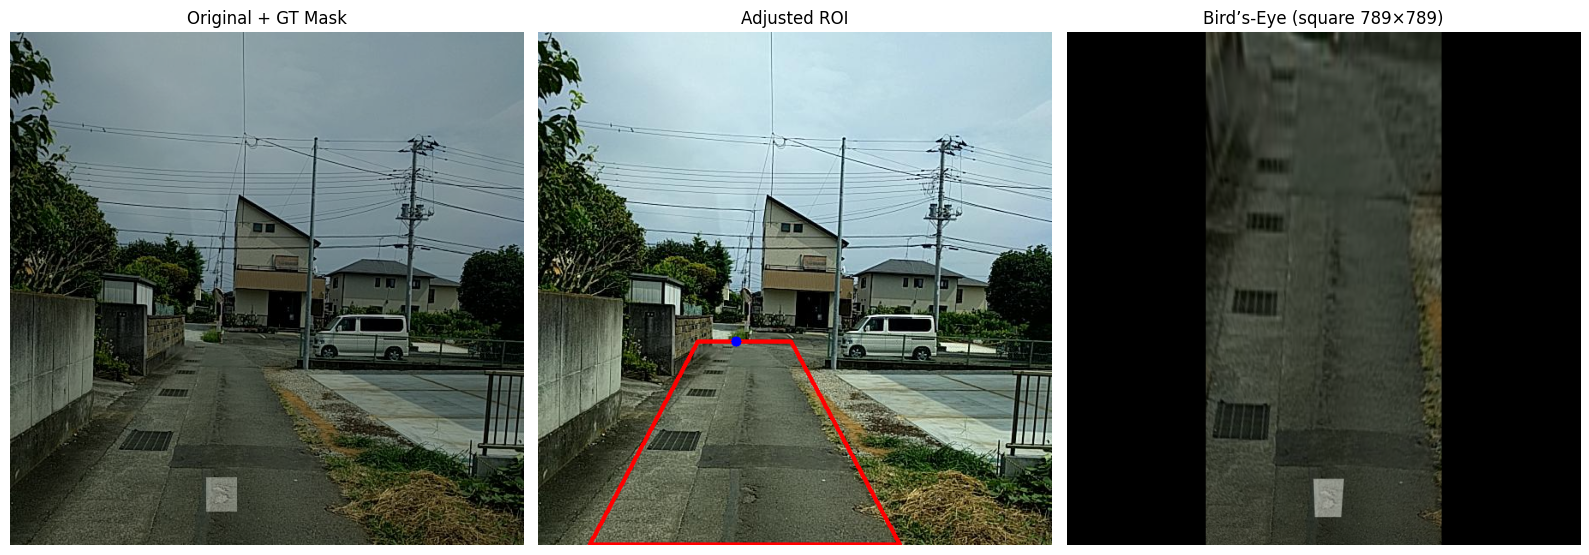

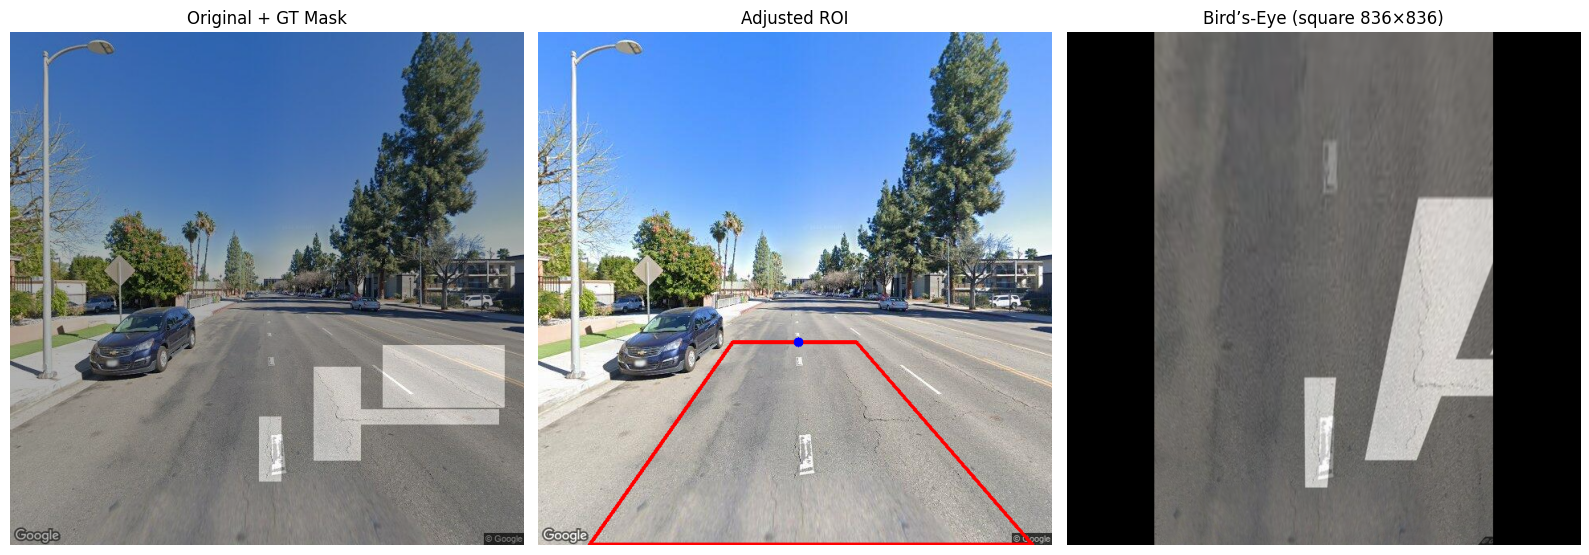

In [112]:
# ──────────────────────────────────────────────────────────────────────────────
# 사용 예시

img_j = "Japan_000040.jpg"
xml_j = "Japan_000040.xml"
dynamic_topview_with_gt_square(

    img_j, xml_j,
    top_width_frac=0.3,
    bottom_frac=0.25,
    use_mask=True
)

img_u = "United_States_000040.jpg"
xml_u = "United_States_000040.xml"
dynamic_topview_with_gt_square(

    img_u, xml_u,
    top_width_frac=0.3,
    bottom_frac=0.25,
    use_mask=True
)
